Exercise 4
A Geiger counter is a device that detects radiation. When an ionizing particle strikes the detector, it outputs a surge of current. The total output at a point in time can be modeled as uncorrelated Poisson (UP) noise, where each sample is a random quantity from a Poisson distribution, which corresponds to the number of particles detected during an interval.
Write a class called UncorrelatedPoissonNoise that inherits from thinkdsp._Noise and provides evaluate. It should use np.random.poisson to generate random values from a Poisson distribution. The parameter of this function, lam, is the average number of particles during each interval. You can use the attribute amp to specify lam. For example, if the frame rate is 10 kHz and amp is 0.001, we expect about 10 “clicks” per second.
Generate about a second of UP noise and listen to it. For low values of amp, like 0.001, it should sound like a Geiger counter. For higher values it should sound like white noise. Compute and plot the power spectrum to see whether it looks like white noise.

蓋革計數器是一種檢測輻射的設備。當電離粒子撞擊檢測器時，它將輸出電流浪湧。在一個時間點上的總輸出可以被建模為非相關的泊松（UP）噪聲，其中每個樣本是來自泊松分佈的隨機量，對應於一個時間間隔內檢測到的粒子數。
編寫一個名為UncorrelatedPoissonNoise的class，該class繼承自thinkdsp._Noise並提供評估。它應該使用np.random.poisson從泊松分佈生成隨機值。該函數的參數lam是每個間隔內的平均粒子數。您可以使用屬性amp指定lam。例如，如果幀速率為10 kHz，安培為0.001，則我們期望每秒約10次“點擊”。
產生大約一秒鐘的UP噪聲並聆聽。對於較低的安培值（例如0.001），它聽起來應該像蓋革計數器。對於更高的值，它聽起來應該像白噪聲。計算並繪製功率譜，看它是否看起來像白噪聲。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

利用bartlett_method製作一個頻譜圖並提取spec_map，spec_map從時間映射到Spectrum objects。它為每個頻譜計算PSD，將它們相加，然後將結果放入Spectrum object。 
wave代表你的波，seg_length代表每段長度。

In [2]:
from thinkdsp import Spectrum

def bartlett_method(wave, seg_length=512, win_flag=True):

    # 製作頻譜圖並提取光譜
    spectro = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectro.spec_map.values()
    
    # 從每個頻譜中提取功率陣列
    psds = [spectrum.power for spectrum in spectrums]
    
    # 計算均值根功率(root mean power)(類似振幅)
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    
    # 用平均振幅繪製頻譜
    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

表示UU noise。
ts代表浮點數陣列的次數。
returns代表浮點數wave的陣列。
lan是每個間隔內的平均粒子數
UncorrelatedUniformNoise 繼承 _Noise。而 _Noise 繼承 Signal。
evaluate 依照 ts 來計算對應的訊號值 ys。

In [3]:
from thinkdsp import Noise

class UncorrelatedPoissonNoise(Noise): #寫一個名為UncorrelatedPoissonNoise的class，該class繼承自thinkdsp._Noise並提供評估。

    def evaluate(self, ts):
        
        ys = np.random.poisson(self.amp, len(ts)) # 它應該使用np.random.poisson從poisson分佈生成隨機值。
        return ys

製造聲音。
振幅為0.001，持續時間1秒，取樣率每秒10000次。
這就是“輻射”水平較低時的聲音。

In [4]:
amp = 0.001
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp) # 振幅為0.001
wave = signal.make_wave(duration=duration, framerate=framerate) # 持續時間1秒，取樣率每秒10000次。
wave.make_audio()

為了檢查是否可運作，我們將粒子的預期數量與實際數量進行比較：

In [5]:
expected = amp * framerate * duration
actual = sum(wave.ys)
print(expected, actual)

10.0 8


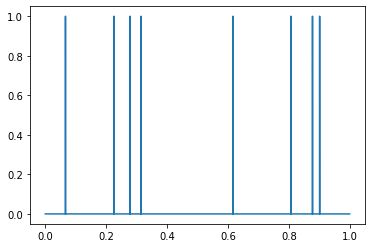

In [6]:
wave.plot()

產生上面聲音的spectrum，下圖為未取log時。

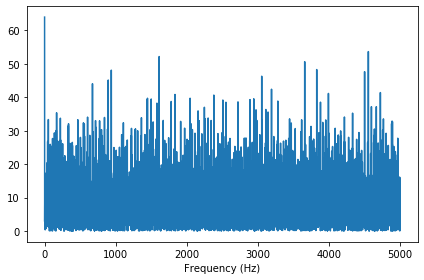

In [7]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)') # x軸為Frequency (Hz)

取log-log。

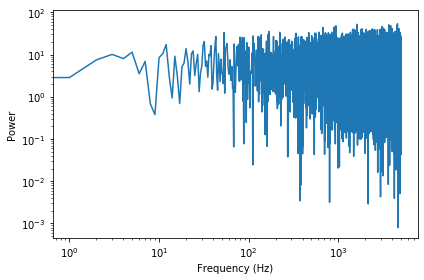

In [8]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
loglog = dict(xscale='log', yscale='log')
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

In [9]:
spectrum.estimate_slope().slope

-0.0021041072355582184

斜率接近0，因此看起來像白噪聲。

將amp改為1，其他不變。

In [10]:
amp = 1
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

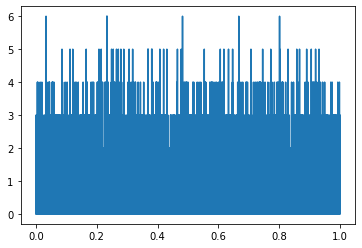

In [11]:
wave.plot()

頻譜收斂於高斯噪聲。

用擬合線繪製正態概率圖。
sample代表數字序列，fit_color代表擬合線的顏色字串，options代表沿著圖經過。
np.random.normal 會回傳 numpy array，裡面的值是高斯分佈。

In [12]:
import matplotlib.pyplot as plt

def normal_prob_plot(sample, fit_color='0.8', **options):
    
    n = len(sample)
    xs = np.random.normal(0, 1, n)
    xs.sort()
    
    ys = np.sort(sample)
    
    mean, std = np.mean(sample), np.std(sample)
    fit_ys = mean + std * xs
    plt.plot(xs, fit_ys, color='gray', alpha=0.5, label='model')

    plt.plot(xs, ys, **options)

製造頻譜。
make_spectrum 使用 rfft，rfft 的結果我叫它為 hs，它是一個numpy提供的複數的 array，可用複數形式來表示波裡面每個頻率成份的振幅與相位移。
每個在 hs 的值，都對應到一個頻率成份。
spectrum.real是回傳hs real的部分(只讀屬性)。

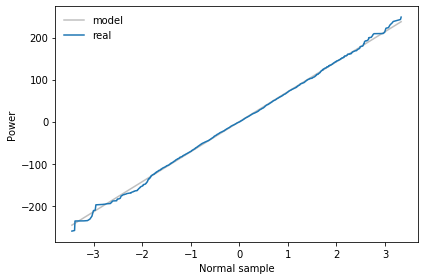

In [14]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0 # 把hs裡頻率=0的元素的值設為 0。

normal_prob_plot(spectrum.real, label='real') # 利用上面的normal_prob_plot產生real線
decorate(xlabel='Normal sample',
        ylabel='Power') # x軸為Normal sample，y軸為Power

spectrum.imag是回傳hs imag的部分(只讀屬性)。

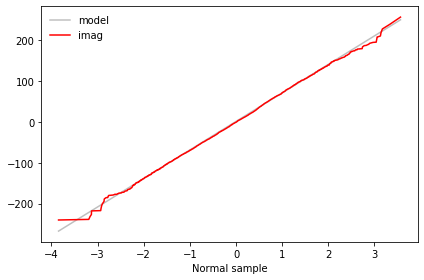

In [15]:
normal_prob_plot(spectrum.imag, label='imag', color='red') #imag線的名字為imag，顏色為紅色。
decorate(xlabel='Normal sample') # x軸為Normal sample